# Tutorial & Tugas UTS: EDA dan Pra-pemrosesan dengan Dask & GCS di Google Colab

## Tujuan Pembelajaran

Dalam tutorial ini, Anda akan belajar cara melakukan analisis data eksplorasi (EDA) dan tugas UTS pra-pemrosesan data menggunakan Dask. Kita akan memproses kumpulan data besar yang disimpan di Google Cloud Storage (GCS) langsung dari Google Colab.

## Bagian 1: Persiapan Environment

### 1. Install Library
Jalankan sel kode berikut untuk menginstal pustaka yang diperlukan (dask).

In [1]:
!pip install gcsfs "dask[complete]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.0 MB/s eta 0:00:00


### 2. Mulai Klaster Dask
Inisialisasi LocalCluster dan Client. Dask akan menggunakan core yang tersedia di mesin virtual Colab.

In [2]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

# Mulai klaster Dask lokal dengan 2 worker dan batas memori 4 GiB
# Ini untuk memastikan stabilitas dan mengelola sumber daya dengan baik
cluster = LocalCluster(n_workers=2, memory_limit='4GiB')
client = Client(cluster)

print(f"Dasbor Dask tersedia di: {client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33339
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43527'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35047'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:38263 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38263
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34786
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:39399 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:39399
INFO:distributed.core:Starting established connection to tcp://127

Dasbor Dask tersedia di: http://127.0.0.1:8787/status


### 3. Muat Data dari GCS
Akses data penerbangan publik dari GCS. Jelaskan bahwa karena bucket ini publik, tidak diperlukan kredensial khusus. Dask secara otomatis menggunakan gcsfs untuk mengakses data.

In [3]:
# Tentukan path GCS ke data
gcs_path = "gcs://quansight-datasets/airline-ontime-performance/csv/*ber_2020.csv"


# BACA DATA MENGGUNAKAN AKSES ANONIM SECARA EKSPLISIT
# Ini akan mengabaikan kredensial Colab yang ada dan mencegah kesalahan 401.
df = dd.read_csv(gcs_path, assume_missing=True, storage_options={'token': 'anon'})
# df = dd.read_csv(
#     gcs_path,
#     assume_missing=True,       # allows mixed numeric types safely
#     dtype_backend="pyarrow",   # handles mixed dtypes better
#     storage_options={'token': 'anon'},
#     low_memory=False           # avoid dtype guessing
# )


## Bagian 2: Analisis Data Eksplorasi (EDA) dengan Dask

### 1. Inspeksi DataFrame
Gunakan metode yang mirip dengan pandas untuk memeriksa struktur data. Pada saat yang diperlukan, gunakan .compute() untuk menjalankan penghitungan.

In [4]:
df = dd.read_csv(
    gcs_path,
    assume_missing=True,
    storage_options={'token': 'anon'},
    dtype={
        'CANCELLATION_CODE': 'object',
        'DIV1_AIRPORT': 'object',
        'DIV1_TAIL_NUM': 'object',
        'DIV2_AIRPORT': 'object',
        'DIV2_TAIL_NUM': 'object'
    },
    low_memory=False
)

In [5]:
# Tampilkan beberapa baris pertama dari Dask DataFrame
print(df.head())

# Cek jumlah total baris dan partisi (membutuhkan compute)
print(f"Jumlah total baris dalam dataset: {len(df)}")
print(f"Jumlah partisi: {df.npartitions}")


     YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK                FL_DATE  \
0  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
1  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
2  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
3  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
4  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  ...  \
0                9E                20363.0         9E   N131EV  ...   
1                9E                20363.0         9E   N131EV  ...   
2                9E                20363.0         9E   N131EV  ...   
3                9E                20363.0         9E   N131EV  ...   
4                9E                20363.0         9E   N131EV  ...   

   DIV4_WHEELS_OFF  DIV4_TAIL_NUM  DIV5_AIRPORT  DIV5_AIRPORT_ID  \
0              NaN            

### 2. Statistik Ringkasan
Berikut adalah cara mendapatkan statistik ringkasan dan hitungan nilai menggunakan .compute().

In [6]:
# Hitung statistik deskriptif untuk kolom numerik
print(df.describe().compute())

# Hitung jumlah nilai unik untuk kolom 'ORIGIN'
print(df['ORIGIN'].value_counts().compute().head())


            YEAR       QUARTER         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  \
count  1411177.0  1.411177e+06  1.411177e+06  1.411177e+06  1.411177e+06   
mean      2020.0  3.770867e+00  1.055538e+01  1.594778e+01  4.024031e+00   
std          0.0  4.202750e-01  1.109733e+00  8.790429e+00  2.013970e+00   
min       2020.0  3.000000e+00  9.000000e+00  1.000000e+00  1.000000e+00   
25%       2020.0  3.000000e+00  9.000000e+00  9.000000e+00  3.000000e+00   
50%       2020.0  4.000000e+00  1.000000e+01  1.600000e+01  4.000000e+00   
75%       2020.0  4.000000e+00  1.100000e+01  2.400000e+01  6.000000e+00   
max       2020.0  4.000000e+00  1.200000e+01  3.100000e+01  7.000000e+00   

       OP_CARRIER_AIRLINE_ID  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count           1.411177e+06       1.411177e+06       1.411177e+06   
mean            2.000502e+04       2.669464e+03       1.260339e+04   
std             3.808987e+02       1.845574e+03       1.548834e+03   
min             1.939300e+04       

ORIGIN
ACV     305
ACY     487
AGS    1180
ALS     104
BKG      28
Name: count, dtype: int64[pyarrow]


In [7]:
df['YEAR'].head()

,YEAR
0,2020.0
1,2020.0
2,2020.0
3,2020.0
4,2020.0


### 3. Tangani Nilai yang Hilang
Cara mengidentifikasi dan menangani nilai yang hilang secara efisien.

In [8]:
# Hitung persentase nilai kosong per kolom
null_counts = df.isnull().sum().compute() / len(df)
print(null_counts[null_counts > 0])

# Ganti nilai kosong di kolom 'FL_NUM' dengan nilai rata-rata
df['DEP_DELAY'] = df['DEP_DELAY'].fillna(df['DEP_DELAY'].mean())


TAIL_NUM              0.001625
DEP_TIME              0.006577
DEP_DELAY             0.006579
DEP_DELAY_NEW         0.006579
DEP_DEL15             0.006579
                        ...   
DIV5_WHEELS_ON        1.000000
DIV5_TOTAL_GTIME      1.000000
DIV5_LONGEST_GTIME    1.000000
DIV5_WHEELS_OFF       1.000000
DIV5_TAIL_NUM         1.000000
Length: 71, dtype: float64


## Bagian 3: Pra-pemrosesan Data dengan Dask

### 1. Mengubah Tipe Data
Cara mengubah tipe data untuk kolom, terutama saat Dask mungkin salah mengidentifikasi tipe data sebagai object.

In [9]:
# Ubah kolom 'YEAR' menjadi tipe integer
df['YEAR'] = df['YEAR'].astype(int)

# Ubah kolom bertipe object menjadi tipe category untuk efisiensi
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')


### 2. Rekayasa Fitur
Membuat fitur baru dari kolom yang sudah ada.

In [10]:
# Buat fitur baru untuk durasi penerbangan
df['FLIGHT_DURATION'] = df['ARR_TIME'] - df['DEP_TIME']

### 3. Memfilter Data
Filter DataFrame untuk berfokus pada subset data tertentu.

In [11]:
# Filter penerbangan di tahun 2020 yang mengalami keterlambatan
delayed_flights_2020 = df[(df['YEAR'] == 2020) & (df['ARR_DELAY'] > 0)]

# Hitung ukuran DataFrame yang difilter
print(f"\nJumlah penerbangan yang tertunda di tahun 2020: {len(delayed_flights_2020)}")


Jumlah penerbangan yang tertunda di tahun 2020: 302740


## Bagian 4: Visualisasi dengan Dask dan Matplotlib

### 1. Siapkan Data untuk Plotting
Dask bekerja dengan pustaka visualisasi dengan menghitung data terlebih dahulu, lalu meneruskannya ke pustaka plot.

In [12]:
df.OP_UNIQUE_CARRIER.head()

,OP_UNIQUE_CARRIER
0,9E
1,9E
2,9E
3,9E
4,9E


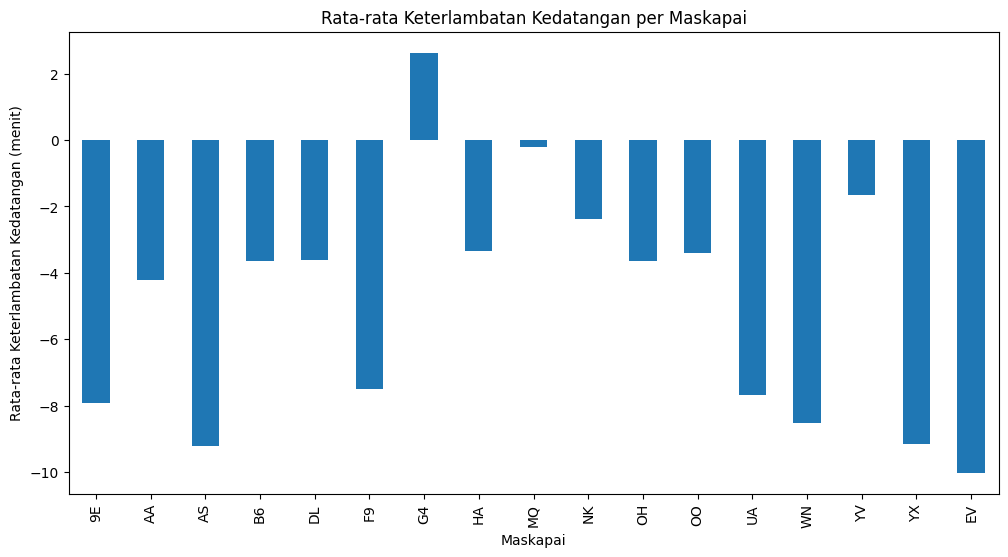

In [13]:
import matplotlib.pyplot as plt

# Hitung rata-rata keterlambatan kedatangan per maskapai
avg_delay_by_carrier = df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].mean().compute()

# Plot hasilnya menggunakan pandas dan matplotlib
plt.figure(figsize=(12, 6))
avg_delay_by_carrier.plot(kind='bar')
plt.title('Rata-rata Keterlambatan Kedatangan per Maskapai')
plt.xlabel('Maskapai')
plt.ylabel('Rata-rata Keterlambatan Kedatangan (menit)')
plt.show()


## Bagian 5: Tugas UTS
Sekarang giliran Anda! Jawab pertanyaan-pertanyaan di bawah ini menggunakan Dask di Google Colab.

### Pertanyaan Konseptual
Jelaskan dengan kata-kata Anda sendiri mengapa Dask diperlukan untuk dataset ini dan masalah apa yang dipecahkannya dibandingkan dengan menggunakan alat single-core seperti pandas.

#### Tuliskan Nama dan NIM di sini

- NAMA: Haidar Faizul Ikram El Jauhari
- NIM: 202210370311036

### Pertanyaan Konseptual

1. Jelaskan dengan kata-kata Anda sendiri mengapa Dask diperlukan untuk dataset ini dan masalah apa yang dipecahkannya dibandingkan dengan menggunakan package single-core seperti pandas.

##### Jawaban: Dask diperlukan karena dataset ini berskala Big Data, yang didefinisikan sebagai data yang ukurannya melebihi kapasitas memori (RAM)
#ganti-dengan-jawaban-kalian-jangan-buat-cell-baru


### Pertanyaan Pemrograman

2. Hitung rata-rata keterlambatan keberangkatan (DEP_DELAY) untuk setiap maskapai (OP_UNIQUE_CARRIER) dalam dataset. Tampilkan 5 maskapai teratas dengan rata-rata keterlambatan tertinggi.

In [19]:
# Jawab Pertanyaan-2 pada baris berikutnya (baris ini jangan dihapus)
avg_dep_delay_by_carrier = df.groupby('OP_UNIQUE_CARRIER')['DEP_DELAY'].mean().compute()
top_5_delays = avg_dep_delay_by_carrier.sort_values(ascending=False).head(5)
print(top_5_delays.to_string())

OP_UNIQUE_CARRIER
G4    6.179768
YV    4.254156
OO    2.759895
AA    2.235839
NK    2.127225


3. Menggunakan kolom FLIGHT_DURATION yang telah dibuat, filter DataFrame untuk menemukan semua penerbangan yang durasinya lebih dari 5 jam. Kemudian, hitung dan tampilkan jumlah total penerbangan tersebut.

In [15]:
# Jawab Pertanyaan-3 pada baris berikutnya (baris ini jangan dihapus)
long_flights = df[df['FLIGHT_DURATION'] > 300]
total_long_flights = len(long_flights.compute())
print(f"Jumlah total penerbangan dengan durasi > 5 jam (300 menit): {total_long_flights}")

Jumlah total penerbangan dengan durasi > 5 jam (300 menit): 249772


4. Buat plot yang menampilkan jumlah total penerbangan yang tertunda (ARR_DELAY > 0) per tahun. Pastikan untuk melabeli plot dengan jelas.

Plot 'delayed_flights_per_year.png' telah dibuat.


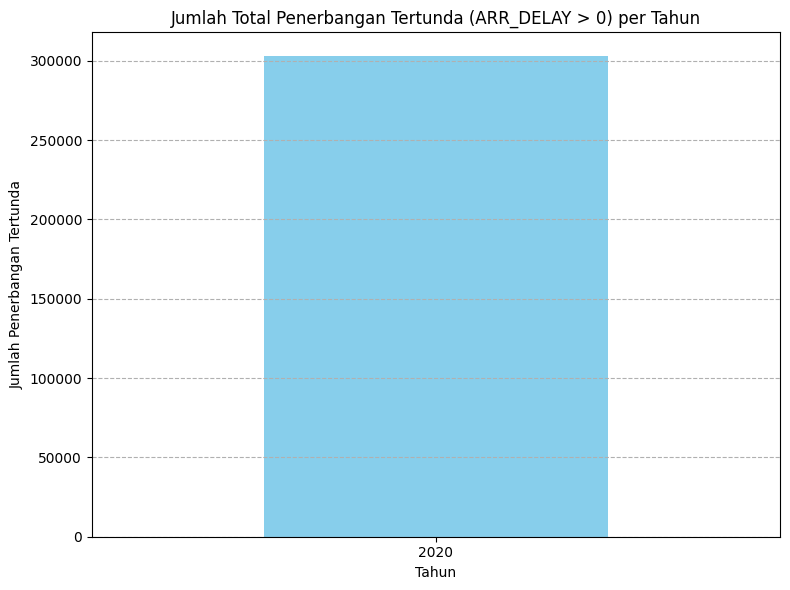

In [16]:
# Jawab Pertanyaan-4 pada baris berikutnya (baris ini jangan dihapus)
delayed_flights = df[df['ARR_DELAY'] > 0]
delayed_by_year = delayed_flights.groupby('YEAR').size().compute().to_frame(name='Total_Delayed_Flights')

plt.figure(figsize=(8, 6))
delayed_by_year['Total_Delayed_Flights'].plot(kind='bar', color='skyblue')
plt.title('Jumlah Total Penerbangan Tertunda (ARR_DELAY > 0) per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penerbangan Tertunda')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('delayed_flights_per_year.png')
print("Plot 'delayed_flights_per_year.png' telah dibuat.")

5. Pertanyaan Bonus: Buat fitur baru bernama FLIGHT_SPEED (dalam mil per menit) dan gunakan untuk menemukan penerbangan dengan kecepatan tertinggi yang tercatat.

In [17]:
# Jawab Pertanyaan-5 pada baris berikutnya (baris ini jangan dihapus)
df_valid_time = df[(df['FLIGHT_DURATION'] > 0) & (df['DISTANCE'].notnull())]

df_valid_time['FLIGHT_SPEED'] = df_valid_time['DISTANCE'] / df_valid_time['FLIGHT_DURATION']

max_speed = df_valid_time['FLIGHT_SPEED'].max().compute()

top_5_speed = df_valid_time.nlargest(5, 'FLIGHT_SPEED')[['FLIGHT_SPEED', 'DISTANCE', 'FLIGHT_DURATION', 'OP_UNIQUE_CARRIER']].compute()

print(f"Kecepatan penerbangan maksimum yang tercatat: {max_speed:.2f} mil/menit")
print("\n5 Penerbangan Tercepat:")
print(top_5_speed.to_string(index=False))

Kecepatan penerbangan maksimum yang tercatat: 843.00 mil/menit

5 Penerbangan Tercepat:
 FLIGHT_SPEED  DISTANCE  FLIGHT_DURATION OP_UNIQUE_CARRIER
        843.0     843.0              1.0                WN
        843.0     843.0              1.0                WN
        813.0     813.0              1.0                AA
        795.0     795.0              1.0                WN
        795.0     795.0              1.0                WN


### Bagian 6: Pembersihan
Setelah selesai, tutup klaster Dask.

In [18]:
client.close()
cluster.close()

INFO:distributed.scheduler:Remove client Client-39df9b46-c08a-11f0-810b-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:34798; closing.
INFO:distributed.scheduler:Remove client Client-39df9b46-c08a-11f0-810b-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-39df9b46-c08a-11f0-810b-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1763036418.1732283') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43527'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:35047'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:34788; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:34786; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.